# Set Up and Getting Data Ready
this part is part of a previously created demo (extract_transform_load_demo.ipynb) with slight modifications

In [1]:
import os
import s3fs
import math
import weave
import random
import matplotlib.pyplot as plt

from weave.pantry import Pantry
from mpl_toolkits import mplot3d
from weave.mongo_loader import MongoLoader
from weave.index.index_pandas import IndexPandas

In [2]:
# connect to minio
s3 = s3fs.S3FileSystem(client_kwargs = {'endpoint_url': os.environ['S3_ENDPOINT']})

In [3]:
# create minio bucket or data space
demo_db = "mongodb-demo"

if s3.exists(demo_db):
    s3.rm(f's3://{demo_db}', recursive = True)
s3.mkdir(demo_db)

In [4]:
# create a pantry
# pandas for the index backend
# mongo for the mongo backend
# this is a function built in house (part of the weave library)
client = weave.config.get_mongo_db()

# you have to include mongo_client variable to upload mongo data
# this is a function built in house (part of the weave library)
demo_pantry = weave.Pantry(
    weave.IndexPandas,
    pantry_path=demo_db,
    file_system=s3,
    mongo_client=client,
)

In [5]:
# upload data from the resources folder
# this will create an index in the bucket
# An Index is an object or file that tracks the baskets in a pantry.
# upload_basket is a function built in house (part of the weave library)
demo_pantry.upload_basket(
    upload_items=[{'path': '/home/jovyan/opal/resources/NASA_MILSTD1553_DTS.yaml', 'stub': False}],
    basket_type='NASA_MILSTD1553_DTS',
)
demo_pantry.upload_basket(
    upload_items=[{'path': '/home/jovyan/opal/resources/NASA_ARINC429_DTS.yaml', 'stub': False}],
    basket_type='NASA_ARINC429_DTS',
)

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,9f2b4c34507c11f0969f0242ac19000b,2025-06-23 21:54:22.589889+00:00,[],NASA_ARINC429_DTS,,1.13.2,mongodb-demo/NASA_ARINC429_DTS/9f2b4c34507c11f...,S3FileSystem


In [6]:
# Ensure the index is up to date
# updates the json files in the index folder in your bucket
index = demo_pantry.index
index.generate_index()

# then get the pandas df representation.
index_df = index.to_pandas_df()
index_df.head()

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,9f2b4c34507c11f0969f0242ac19000b,2025-06-23 21:54:22.589889+00:00,[],NASA_ARINC429_DTS,,1.13.2,mongodb-demo/NASA_ARINC429_DTS/9f2b4c34507c11f...,S3FileSystem
1,9ead5518507c11f0969f0242ac19000b,2025-06-23 21:54:21.764377+00:00,[],NASA_MILSTD1553_DTS,,1.13.2,mongodb-demo/NASA_MILSTD1553_DTS/9ead5518507c1...,S3FileSystem


In [7]:
print(f"Index length: {len(index)}")
# basket_type is a pandas function
# https://pandas.pydata.org/docs/reference/api/pandas.Series.html
# basket is a Series attribute
index_df.basket_type.value_counts()

Index length: 2


basket_type
NASA_ARINC429_DTS      1
NASA_MILSTD1553_DTS    1
Name: count, dtype: int64

In [8]:
# generating some more interesting data
# this is the purpose of metadata. to store a snap shot of the entire dataset. in this trivial example lets say we have the altitude,
# and speed for every second of a 2 hour flight. there is also a singular data point of how much fuel was burned. a big purpose of using
# pymongo is that we can store some interesting data points about the data so we can quickly know about the dataset. faster to query
# singular data points such as max_altitude to know more about a particular dataset rather than looking at every altitude data point.
max_altitude = 8_000
for i in range(0,25):
    max_speed = math.floor(900 * random.uniform(1, 2.1))
    fuel_burned = math.floor(max_speed * random.uniform(4.5, 5.2) + random.uniform(-150, 250))
    demo_pantry.upload_basket(
        upload_items=[{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': False}],
        basket_type='ch10',
        metadata = {'ch10name': '652200104150842', 'max_altitude': max_altitude, 'max_speed': max_speed, 'fuel_burned': fuel_burned},
    )
    max_altitude += 350

In [9]:
# Ensure the index is up to date
# updates the json files in the index folder in your bucket
index = demo_pantry.index
index.generate_index()

# then get the pandas df representation.
index_df = index.to_pandas_df()
index_df.head()

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,9f2b4c34507c11f0969f0242ac19000b,2025-06-23 21:54:22.589889+00:00,[],NASA_ARINC429_DTS,,1.13.2,mongodb-demo/NASA_ARINC429_DTS/9f2b4c34507c11f...,S3FileSystem
1,9ead5518507c11f0969f0242ac19000b,2025-06-23 21:54:21.764377+00:00,[],NASA_MILSTD1553_DTS,,1.13.2,mongodb-demo/NASA_MILSTD1553_DTS/9ead5518507c1...,S3FileSystem
2,9f936b34507c11f0969f0242ac19000b,2025-06-23 21:54:23.276419+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/9f936b34507c11f0969f0242ac19...,S3FileSystem
3,9fe1e188507c11f0969f0242ac19000b,2025-06-23 21:54:23.767694+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/9fe1e188507c11f0969f0242ac19...,S3FileSystem
4,a0247020507c11f0969f0242ac19000b,2025-06-23 21:54:24.257143+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a0247020507c11f0969f0242ac19...,S3FileSystem


In [10]:
print(f"Index length: {len(index)}")
# basket_type is a pandas function
# https://pandas.pydata.org/docs/reference/api/pandas.Series.html
# basket is a Series attribute
index_df.basket_type.value_counts()

Index length: 27


basket_type
ch10                   25
NASA_ARINC429_DTS       1
NASA_MILSTD1553_DTS     1
Name: count, dtype: int64

# MongoDB Tutorial

In [11]:
# initalizing a mongo database for the demo pantry
# this is a function built in house (part of the weave library)
# https://github.com/309thEDDGE/weave/blob/main/weave/mongo_loader.py
# above is where most of the functions built in house for mongo is
mongo = MongoLoader(pantry=demo_pantry, mongo_client=client)

In [12]:
# the rest of these functions used in this notebook are standard pymongo functions
# this is just to get you familiar with pymongo not an extensive pymongo tutorial
# printing the database name
print(mongo.database_name)

# setting a variable for the mongo dataase
mongodb = mongo.database
print(mongodb)

mongodb-demo
Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo')


In [13]:
# getting collection names (basically table names in a relational database)
collection_names = mongodb.list_collection_names()
for name in collection_names:
    print(name)

# a different way
mongodb.list_collection_names()

supplement
metadata
manifest


['supplement', 'metadata', 'manifest']

In [14]:
# getting each collection its own variable
manifest_collection = mongodb[mongo.manifest_collection]
print(manifest_collection)
print(manifest_collection.count_documents({}))

metadata_collection = mongodb[mongo.metadata_collection]
print(metadata_collection)
print(metadata_collection.count_documents({}))

supplement_collection = mongodb[mongo.supplement_collection]
print(supplement_collection)
print(supplement_collection.count_documents({}))

Collection(Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo'), 'manifest')
27
Collection(Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo'), 'metadata')
25
Collection(Database(MongoClient(host=['mongodb:27017'], document_class=dict, tz_aware=False, connect=True, timeoutms=0.0), 'mongodb-demo'), 'supplement')
27


In [15]:
# getting the unique fieldnames (keys) for a collection 
def get_unique_fieldnames(collection):
    fieldnames = set()
    for doc in collection.find():
        def extract_keys(d, prefix=''):
            for k, v in d.items():
                full_key = f"{prefix}.{k}" if prefix else k
                fieldnames.add(full_key)
                if isinstance(v, dict):
                    extract_keys(v, full_key)
                elif isinstance(v, list):
                    for item in v:
                        if isinstance(item, dict):
                            extract_keys(item, full_key)
        extract_keys(doc)
    return fieldnames

# getting field names for each collection
manifest_fn = get_unique_fieldnames(manifest_collection)
metadata_fn = get_unique_fieldnames(metadata_collection)
supplement_fn = get_unique_fieldnames(supplement_collection)

print("Manifest fieldnames:", manifest_fn, "\n")
print("Metadata fieldnames: ", metadata_fn, "\n")
print("Supplement fieldnames: ", supplement_fn, "\n")

Manifest fieldnames: {'_id', 'uuid', 'parent_uuids', 'label', 'basket_type', 'upload_time', 'weave_version'} 

Metadata fieldnames:  {'_id', 'uuid', 'max_speed', 'fuel_burned', 'ch10name', 'max_altitude', 'basket_type'} 

Supplement fieldnames:  {'_id', 'integrity_data.access_date', 'integrity_data.byte_count', 'upload_items.stub', 'uuid', 'upload_items', 'integrity_data.upload_path', 'integrity_data.hash', 'basket_type', 'integrity_data.stub', 'integrity_data.source_path', 'integrity_data.file_size', 'integrity_data', 'upload_items.path'} 



In [16]:
# printing out the first 3 items in the metadata collection
print(list(metadata_collection.find({}))[0:3])
print(metadata_collection.count_documents({}))

[{'_id': ObjectId('6859cd0f85cf1eedc74e1779'), 'uuid': '9f936b34507c11f0969f0242ac19000b', 'basket_type': 'ch10', 'ch10name': '652200104150842', 'max_altitude': 8000, 'max_speed': 1286, 'fuel_burned': 6425}, {'_id': ObjectId('6859cd1085cf1eedc74e177c'), 'uuid': '9fe1e188507c11f0969f0242ac19000b', 'basket_type': 'ch10', 'ch10name': '652200104150842', 'max_altitude': 8350, 'max_speed': 1486, 'fuel_burned': 7475}, {'_id': ObjectId('6859cd1085cf1eedc74e177f'), 'uuid': 'a0247020507c11f0969f0242ac19000b', 'basket_type': 'ch10', 'ch10name': '652200104150842', 'max_altitude': 8700, 'max_speed': 1500, 'fuel_burned': 7122}]
25


In [17]:
# printing out the first 3 items in the manifest collection
print(list(manifest_collection.find({}))[0:3])
print(manifest_collection.count_documents({}))

[{'_id': ObjectId('6859cd0e85cf1eedc74e1775'), 'uuid': '9ead5518507c11f0969f0242ac19000b', 'upload_time': '2025-06-23T21:54:21.764377+00:00', 'parent_uuids': [], 'basket_type': 'NASA_MILSTD1553_DTS', 'label': '', 'weave_version': '1.13.2'}, {'_id': ObjectId('6859cd0e85cf1eedc74e1777'), 'uuid': '9f2b4c34507c11f0969f0242ac19000b', 'upload_time': '2025-06-23T21:54:22.589889+00:00', 'parent_uuids': [], 'basket_type': 'NASA_ARINC429_DTS', 'label': '', 'weave_version': '1.13.2'}, {'_id': ObjectId('6859cd0f85cf1eedc74e177a'), 'uuid': '9f936b34507c11f0969f0242ac19000b', 'upload_time': '2025-06-23T21:54:23.276419+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}]
27


In [18]:
# printing out the first 3 items in the supplement collection
print(list(supplement_collection.find({}))[0:3])
print(supplement_collection.count_documents({}))

[{'_id': ObjectId('6859cd0e85cf1eedc74e1776'), 'uuid': '9ead5518507c11f0969f0242ac19000b', 'basket_type': 'NASA_MILSTD1553_DTS', 'integrity_data': [{'file_size': 3534, 'hash': 'a791b73b5aed00c6659d0519a48dd11fd365b25c2e5b42fa626641e634a211b8', 'access_date': '2025-06-23T21:54:21.724773+00:00', 'source_path': '/home/jovyan/opal/resources/NASA_MILSTD1553_DTS.yaml', 'byte_count': 100000000, 'stub': False, 'upload_path': 'mongodb-demo/NASA_MILSTD1553_DTS/9ead5518507c11f0969f0242ac19000b/NASA_MILSTD1553_DTS.yaml'}], 'upload_items': [{'path': '/home/jovyan/opal/resources/NASA_MILSTD1553_DTS.yaml', 'stub': False}]}, {'_id': ObjectId('6859cd0e85cf1eedc74e1778'), 'uuid': '9f2b4c34507c11f0969f0242ac19000b', 'basket_type': 'NASA_ARINC429_DTS', 'integrity_data': [{'file_size': 5341, 'hash': '21f6e2e255ebd61662e9311b47cf6b915bd28d5d7e36d4f1f15e67182b2cd884', 'access_date': '2025-06-23T21:54:22.521170+00:00', 'source_path': '/home/jovyan/opal/resources/NASA_ARINC429_DTS.yaml', 'byte_count': 10000000

In [19]:
# find one item with a basket_type of ch10 in the manifest collection
ch10_find_one = manifest_collection.find_one({"basket_type": "ch10"})
print(ch10_find_one)

{'_id': ObjectId('6859cd0f85cf1eedc74e177a'), 'uuid': '9f936b34507c11f0969f0242ac19000b', 'upload_time': '2025-06-23T21:54:23.276419+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}


In [20]:
# print all of the items that has a weave version of 1.13.2 in the manifest collection
weave_ver_find = manifest_collection.find({"weave_version": "1.13.2"})
print(weave_ver_find)

for i in range(0, 5):
    print(weave_ver_find[i])
print("\n")

# different weave version not in data
weave_ver_find = manifest_collection.find({"weave_version": "589.13.4"})
print(weave_ver_find)

# nothing was printed
for single_item in weave_ver_find:
    print(single_item)

{'_id': ObjectId('6859cd0e85cf1eedc74e1775'), 'uuid': '9ead5518507c11f0969f0242ac19000b', 'upload_time': '2025-06-23T21:54:21.764377+00:00', 'parent_uuids': [], 'basket_type': 'NASA_MILSTD1553_DTS', 'label': '', 'weave_version': '1.13.2'}
{'_id': ObjectId('6859cd0e85cf1eedc74e1777'), 'uuid': '9f2b4c34507c11f0969f0242ac19000b', 'upload_time': '2025-06-23T21:54:22.589889+00:00', 'parent_uuids': [], 'basket_type': 'NASA_ARINC429_DTS', 'label': '', 'weave_version': '1.13.2'}
{'_id': ObjectId('6859cd0f85cf1eedc74e177a'), 'uuid': '9f936b34507c11f0969f0242ac19000b', 'upload_time': '2025-06-23T21:54:23.276419+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}
{'_id': ObjectId('6859cd1085cf1eedc74e177d'), 'uuid': '9fe1e188507c11f0969f0242ac19000b', 'upload_time': '2025-06-23T21:54:23.767694+00:00', 'parent_uuids': [], 'basket_type': 'ch10', 'label': '', 'weave_version': '1.13.2'}
{'_id': ObjectId('6859cd1085cf1eedc74e1780'), 'uuid': 'a0247020507c11f0969f0

In [21]:
# getting uuid for each item in the manifest collection
all_uuids_find = manifest_collection.find({}, {'uuid': True})
print(all_uuids_find)
print(len(list(all_uuids_find.clone())))

for i in range(0, 5):
    print(all_uuids_find[i]['uuid'])

27
9ead5518507c11f0969f0242ac19000b
9f2b4c34507c11f0969f0242ac19000b
9f936b34507c11f0969f0242ac19000b
9fe1e188507c11f0969f0242ac19000b
a0247020507c11f0969f0242ac19000b


In [22]:
# printing out all the uuids for each item in the manifest collection using the find() function in a different way
for i in range(0, 5):
    object_id = manifest_collection.find()[i]['uuid']
    print(object_id)

# can be done this way but do not want to print out all uuids
# for document in manifest_collection.find():
#     object_id = document['uuid']
#     print(object_id)

9ead5518507c11f0969f0242ac19000b
9f2b4c34507c11f0969f0242ac19000b
9f936b34507c11f0969f0242ac19000b
9fe1e188507c11f0969f0242ac19000b
a0247020507c11f0969f0242ac19000b


In [23]:
# another example to get uuids by using the distinct function to get all uuids (trivial example to show some different functions,
# since all uuids are distinct)
manifest_ids = manifest_collection.distinct('uuid')
print(len(manifest_ids))
print(manifest_ids[0:10])

27
['9ead5518507c11f0969f0242ac19000b', '9f2b4c34507c11f0969f0242ac19000b', '9f936b34507c11f0969f0242ac19000b', '9fe1e188507c11f0969f0242ac19000b', 'a0247020507c11f0969f0242ac19000b', 'a084b75a507c11f0969f0242ac19000b', 'a0e232ea507c11f0969f0242ac19000b', 'a1459f56507c11f0969f0242ac19000b', 'a1b45824507c11f0969f0242ac19000b', 'a23f4c86507c11f0969f0242ac19000b']


# Less trival examples

In [24]:
# getting all documents' uuid's in metadata_collection that follows the query below
# max_altitude > 10_000
# max_speed < 1_450
# fuel_burned >= 6_000 amd <= 8_000
query = {"max_altitude": {"$gt": 10_000}, "max_speed": {"$lt": 1_450}, "fuel_burned": {"$gte": 6_000, "$lte": 8_000}}

doc_uuids = []
for doc in metadata_collection.find(query):
    doc_uuids.append(doc['uuid'])

print(f"There are {len(doc_uuids)} out of {metadata_collection.count_documents({})} documents that satisfy the above query")
print(f"Those documents' uuid's are \n{doc_uuids}")

There are 4 out of 25 documents that satisfy the above query
Those documents' uuid's are 
['a436c76c507c11f0969f0242ac19000b', 'a55a6b30507c11f0969f0242ac19000b', 'a645753a507c11f0969f0242ac19000b', 'a7f43560507c11f0969f0242ac19000b']


In [25]:
# only 25 documents have metadata (was entered when it was uploaded to the basket)
# two documents do not have metadata
print(metadata_collection.count_documents({}))

25


In [26]:
# adding more data
# automatically gets uploaded to the mongodb
max_altitude = 8_000
for i in range(0,25):
    max_speed = math.floor(900 * random.uniform(1, 2.1))
    fuel_burned = math.floor(max_speed * random.uniform(4.5, 5.2) + random.uniform(-150, 250))
    demo_pantry.upload_basket(
        upload_items=[{'path': '/home/jovyan/opal/resources/652200104150842.ch10', 'stub': False}],
        basket_type='ch10_2',
        metadata = {'ch10name': '652200104150842', 'max_altitude': max_altitude, 'max_speed': max_speed, 'fuel_burned': fuel_burned},
    )
    max_altitude += 350

In [27]:
index = demo_pantry.index
index.generate_index()

# then get the pandas df representation.
index_df = index.to_pandas_df()
index_df.head()

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,9f2b4c34507c11f0969f0242ac19000b,2025-06-23 21:54:22.589889+00:00,[],NASA_ARINC429_DTS,,1.13.2,mongodb-demo/NASA_ARINC429_DTS/9f2b4c34507c11f...,S3FileSystem
1,9ead5518507c11f0969f0242ac19000b,2025-06-23 21:54:21.764377+00:00,[],NASA_MILSTD1553_DTS,,1.13.2,mongodb-demo/NASA_MILSTD1553_DTS/9ead5518507c1...,S3FileSystem
2,9f936b34507c11f0969f0242ac19000b,2025-06-23 21:54:23.276419+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/9f936b34507c11f0969f0242ac19...,S3FileSystem
3,9fe1e188507c11f0969f0242ac19000b,2025-06-23 21:54:23.767694+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/9fe1e188507c11f0969f0242ac19...,S3FileSystem
4,a0247020507c11f0969f0242ac19000b,2025-06-23 21:54:24.257143+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a0247020507c11f0969f0242ac19...,S3FileSystem


In [28]:
# the 25 items are now in minio as ch10_2 basket type
print(f"Index length: {len(index)}")
index_df.basket_type.value_counts()

Index length: 52


basket_type
ch10_2                 25
ch10                   25
NASA_MILSTD1553_DTS     1
NASA_ARINC429_DTS       1
Name: count, dtype: int64

In [29]:
# those 25 items uploaded to minio are also in the mongodb
# now we have 50 documents that have a metadata collection
metadata_collection = mongodb[mongo.metadata_collection]
print(metadata_collection.count_documents({}))

50


In [30]:
# lets see how many documents satisfy the same query
query = {"max_altitude": {"$gt": 10_000}, "max_speed": {"$lt": 1_450}, "fuel_burned": {"$gte": 6_000, "$lte": 8_000}}

doc_uuids = []
for doc in metadata_collection.find(query):
    doc_uuids.append(doc['uuid'])

print(f"There are {len(doc_uuids)} out of {metadata_collection.count_documents({})} documents that satisfy the above query")
print(f"Those documents' uuid's are \n{doc_uuids}")

There are 8 out of 50 documents that satisfy the above query
Those documents' uuid's are 
['a436c76c507c11f0969f0242ac19000b', 'a55a6b30507c11f0969f0242ac19000b', 'a645753a507c11f0969f0242ac19000b', 'a7f43560507c11f0969f0242ac19000b', 'acb715e0507c11f0969f0242ac19000b', 'ae6d2ca8507c11f0969f0242ac19000b', 'b00a3db2507c11f0969f0242ac19000b', 'b093f598507c11f0969f0242ac19000b']


# Graph the Data

In [31]:
labels = []
max_speed_data = []
fuel_burned_data = []
max_altitude_data = []

# get data for the graph
for doc in metadata_collection.find():
    # if it satisfied the query from above then add True to label
    # this is so we can have those labels be a different color
    # from the rest
    if doc['uuid'] in doc_uuids:
        labels.append(True)
    else:
        labels.append(False)
    max_speed_data.append(doc['max_speed'])
    fuel_burned_data.append(doc['fuel_burned'])
    max_altitude_data.append(doc['max_altitude'])

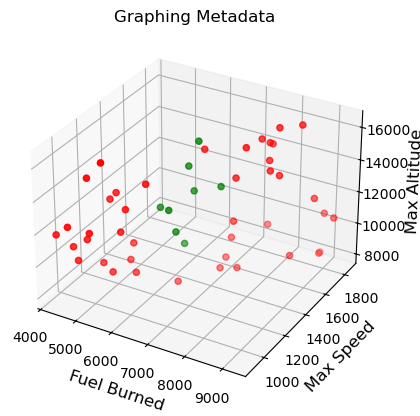

In [32]:
# create 3d axes
fig = plt.figure()
ax = plt.axes(projection='3d')
 
# data
x = fuel_burned_data
y = max_speed_data
z = max_altitude_data
colors = ['green' if label == True else 'red' for label in labels]
ax.scatter(x, y, z, c=colors)

ax.set_title('Graphing Metadata', fontsize=12)
ax.set_xlabel('Fuel Burned', fontsize=12)
ax.set_ylabel('Max Speed', fontsize=12)
ax.set_zlabel('Max Altitude', fontsize=12)
 
plt.show()

# Inserting More Data

In [33]:
# if you need to upload baskets to the mongodb when you did not give weave.Pantry a mongo_client
# this is for example purposes becuase you can just upload the basket like previously in the notebook
demo_pantry_2 = weave.Pantry(
    weave.IndexPandas,
    pantry_path=demo_db,
    file_system=s3,
)

demo_index_2 = demo_pantry_2.index

average_speed = 2_000
for i in range(0,5):
    average_speed = average_speed + 250
    demo_pantry_2.upload_basket(
        upload_items=[{'path': '/home/jovyan/opal/resources/NASA_MILSTD1553_DTS.yaml', 'stub': False}],
        basket_type='ex1',
        metadata = {'average_speed': average_speed},
    )

In [34]:
# Ensure the index is up to date
# updates the json files in the index folder in your bucket
index_2 = demo_pantry_2.index
index_2.generate_index()

# then get the pandas df representation.
# new item is at the bottom
index_df_2 = index_2.to_pandas_df()
index_df_2.head()

,uuid,upload_time,parent_uuids,basket_type,label,weave_version,address,storage_type
0,9f2b4c34507c11f0969f0242ac19000b,2025-06-23 21:54:22.589889+00:00,[],NASA_ARINC429_DTS,,1.13.2,mongodb-demo/NASA_ARINC429_DTS/9f2b4c34507c11f...,S3FileSystem
1,9ead5518507c11f0969f0242ac19000b,2025-06-23 21:54:21.764377+00:00,[],NASA_MILSTD1553_DTS,,1.13.2,mongodb-demo/NASA_MILSTD1553_DTS/9ead5518507c1...,S3FileSystem
2,9f936b34507c11f0969f0242ac19000b,2025-06-23 21:54:23.276419+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/9f936b34507c11f0969f0242ac19...,S3FileSystem
3,9fe1e188507c11f0969f0242ac19000b,2025-06-23 21:54:23.767694+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/9fe1e188507c11f0969f0242ac19...,S3FileSystem
4,a0247020507c11f0969f0242ac19000b,2025-06-23 21:54:24.257143+00:00,[],ch10,,1.13.2,mongodb-demo/ch10/a0247020507c11f0969f0242ac19...,S3FileSystem


In [35]:
# should still be at 50 since we did not upload the new data to the mongo database
metadata_collection = mongodb[mongo.metadata_collection]
print(metadata_collection.count_documents({}))

50


In [36]:
# the ex1 basket is in minio but not in mongo database
print(f"Index length: {len(index)}")
index_df_2.basket_type.value_counts()

Index length: 57


basket_type
ch10                   25
ch10_2                 25
ex1                     5
NASA_ARINC429_DTS       1
NASA_MILSTD1553_DTS     1
Name: count, dtype: int64

In [37]:
# getting the uuids from the newly created baskets
# the newly created baskets are all of basket type 'ex1'
# the line of code is just pandas df code (no weave or opal specific fucntions)
ex1_uuids = list((index_df_2.loc[index_df_2['basket_type']=='ex1', 'uuid']))
print(ex1_uuids)
print(len(ex1_uuids))

['b72ee8a4507c11f0969f0242ac19000b', 'b912c208507c11f0969f0242ac19000b', 'b944172c507c11f0969f0242ac19000b', 'b981e5d4507c11f0969f0242ac19000b', 'b9cb0660507c11f0969f0242ac19000b']
5


In [38]:
# uploading items to the mongo database manually (all you need is the items' uuid to upload to mongo)
for uuid in ex1_uuids:
    mongo.load_mongo(uuid)

In [39]:
# should be 55 now since the documents were uploaded to the mongo database
metadata_collection = mongodb[mongo.metadata_collection]
print(metadata_collection.count_documents({}))

55


# Cleanup

In [40]:
# removing demo basket
if s3.exists(demo_db):
    s3.rm(f's3://{demo_db}', recursive = True)

In [41]:
# clearing mongo database
mongo.clear_mongo()